# 2D Recurrent Neural Network Position Model

### Load Data

In [8]:
NUM_ITERS = 100

NUM_CLASSES = 2
NUM_HIDDEN = 30
ROLLOUT = None
LEARNING_RATE = 0.005
REGULARIZER = 0

In [9]:
%store -r shots

df = shots['df']
sideways = df.T

X, Y = np.array(sideways.ix[['dist0', 'theta0']]).astype(float), np.array(sideways.ix['label']).astype(int)

### Data

/home/ebanner/.anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:3: DeprecationWarning: non integer (and non boolean) array-likes will not be accepted as indices in the future
  app.launch_new_instance()
/home/ebanner/.anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:4: DeprecationWarning: non integer (and non boolean) array-likes will not be accepted as indices in the future


/home/ebanner/.anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


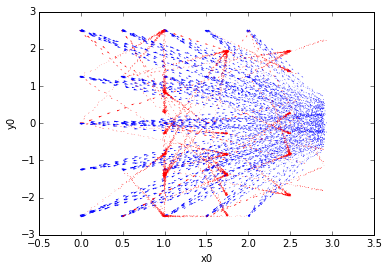

In [10]:
colormap = np.array(['r', 'b'])
labels = df['label']
axes = df.plot(kind='scatter', x='x0', y='y0', c=colormap[labels], s=0)
axes.quiver(df['x0'], df['y0'], df['dx0'], df['dy0'], color=colormap[labels], scale_units='xy', angles='xy', scale=2.5, headwidth=2)

### Train

In [11]:
from rnn.model import RecurrentNeuralNetwork

rnn = RecurrentNeuralNetwork(X, Y, H=NUM_HIDDEN, C=NUM_CLASSES, rollout=ROLLOUT, learning_rate=LEARNING_RATE, regularizer=REGULARIZER, gradient_checking=False, inspect=True)

def states(iters):
    for i in range(iters):
        if not i % 10:
            print('{}%...'.format((i/NUM_ITERS)*100, end=''))
                  
        rnn.learn()
        yield rnn.info
        
states = list(states(NUM_ITERS))

0.0%...
10.0%...
20.0%...
30.0%...
40.0%...
50.0%...
60.0%...
70.0%...
80.0%...
90.0%...


### Plot Losses

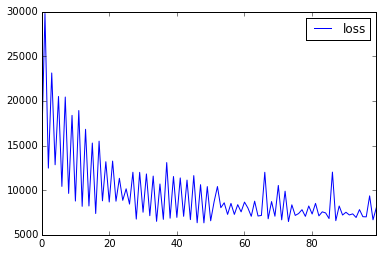

In [12]:
def loss_averages():
    for state in states:
        yield state.loss
        
losses = list(loss_averages())

pd.DataFrame(losses, columns=['loss']).plot()

### Visualize

/home/ebanner/.anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:18: DeprecationWarning: non integer (and non boolean) array-likes will not be accepted as indices in the future
/home/ebanner/.anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:19: DeprecationWarning: non integer (and non boolean) array-likes will not be accepted as indices in the future
/home/ebanner/.anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:29: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
/home/ebanner/.anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:30: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
/home/ebanner/.anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('f

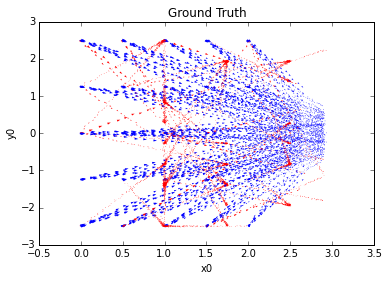

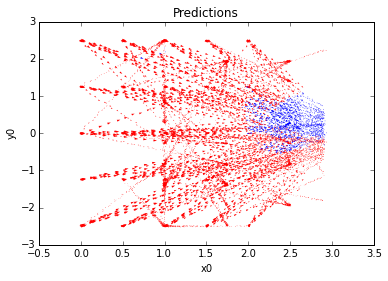

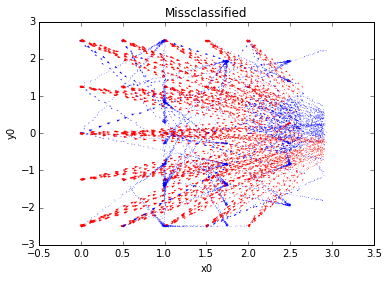

In [13]:
from ipywidgets import interact, fixed

@interact(X=fixed(X), Y=fixed(Y), view_index=(0, len(states)-1), states=fixed(states))
def plot(X, Y, view_index, states):
    """View decision boundary over time
    
    We have the state of the model (i.e. its parameters) after every time step.
    We want to see how the model learns over time. Hence create a one-off instance
    of a softmax with its old parameters and ask it to make a bunch of predictions!
    """
    s = states[view_index]
    nn = RecurrentNeuralNetwork(X, Y, H=NUM_HIDDEN, C=NUM_CLASSES, Whh=s.Whh, bhh=s.bhh, Wxh=s.Wxh, bxh=s.bxh)
    
    # Plotting
    colormap = np.array(['r', 'b'])

    # Plot the gold standard in a plot right next to it
    axes = df.plot(kind='scatter', x='x0', y='y0', c=colormap[df['label']], title='Ground Truth', s=0)
    axes.quiver(df['x0'], df['y0'], df['dx0'], df['dy0'], color=colormap[df['label']], scale_units='xy', angles='xy', scale=2.5, width=.0022)

    # Predictions
    scores, predictions = rnn.predict(X)
    df['predictions'] = predictions
    axes = df.plot(kind='scatter', x='x0', y='y0', c=colormap[df['predictions']], title='Predictions', s=0)
    axes.quiver(df['x0'], df['y0'], df['dx0'], df['dy0'], color=colormap[df['predictions']], scale_units='xy', angles='xy', scale=2.5, width=.0022)

    # Misclassified examples
    df['correct'] = df['label'] == df['predictions']
    axes = df.plot(kind='scatter', x='x0', y='y0', c=colormap[df['correct']], title='Missclassified', s=0)
    axes.quiver(df['x0'], df['y0'], df['dx0'], df['dy0'], color=colormap[df['correct']], scale_units='xy', angles='xy', scale=2.5, width=.0022)

In [14]:
df['correct'].sum() / len(df)

0.63770334928229666